# Projet MLOps – Modélisation

## Objectifs

Ce notebook a pour objectif de mettre en œuvre la phase de modélisation du projet MLOps.
À partir des données prétraitées, il s’agit d’entraîner et de comparer plusieurs modèles de classification afin de prédire le niveau de revenu (>50K / ≤50K). Le notebook couvre l’ensemble du processus de modélisation : séparation des données en jeux d’entraînement et de test, entraînement des modèles, évaluation des performances à l’aide de métriques adaptées (Accuracy, Recall, F1-score, ROC-AUC), ainsi que l’optimisation des modèles pour mieux gérer le déséquilibre des classes.
Enfin, cette étape permet de sélectionner le modèle final le plus pertinent, qui sera sauvegardé et réutilisé dans une logique MLOps pour la phase de prédiction automatisée.

## Bibliothèques

In [62]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt

#modele regression logistique
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

#sauvegarde model final random forest
from pathlib import Path
import joblib



## Importation des données

In [31]:
DATA_PATH = "../data/modelisation/data_modeling.csv"   # adapte si ton fichier est ailleurs
df_model = pd.read_csv(DATA_PATH)

print("✅ Dataset chargé")
print("Shape:", df_model.shape)
display(df_model.head())



✅ Dataset chargé
Shape: (48842, 7)


,education,age,hours_per_week,occupation,capital_gain,marital_status,income
0,Middle_Low,Entre 18 et 30 ans,normally_employed,Blue Collar,Pas de gain de capital,Never_married,<=50K
1,HighSchool_SomeCollege,Entre 31 et 50 ans,over_employed,Agriculture,Pas de gain de capital,Married,<=50K
2,HighSchool_SomeCollege,Entre 18 et 30 ans,normally_employed,Protective Services,Pas de gain de capital,Married,>50K
3,HighSchool_SomeCollege,Entre 31 et 50 ans,normally_employed,Blue Collar,Gain de capital,Married,>50K
4,HighSchool_SomeCollege,Entre 18 et 30 ans,under_employed,Other,Pas de gain de capital,Never_married,<=50K


## Entraînement

Le jeu de données étant composé d’environ 48 842 observations, nous réalisons une séparation train/test en 80/20. Ce choix permet de conserver une quantité suffisante de données pour l’apprentissage tout en réservant un échantillon de test assez grand pour obtenir une évaluation stable. La séparation est stratifiée sur la variable cible afin de préserver la distribution des classes.

In [32]:
# =========================
# 3) Séparation X / y
# =========================
target = "income"

X = df_model.drop(columns=[target]).copy()
y = df_model[target].copy()

# Binaire (utile pour AUC/ROC) : 1 si >50K, 0 sinon
y_bin = (y == ">50K").astype(int)

print("✅ X / y prêts")
print("X shape:", X.shape)
print("y shape:", y.shape)


# =========================
# 4) Split train / test (stratifié)
# =========================
X_train, X_test, y_train, y_test, y_train_bin, y_test_bin = train_test_split(
    X, y, y_bin,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\n✅ Split terminé")
print("Train:", X_train.shape, "| Test:", X_test.shape)

print("\nRépartition y_train (%):")
display((y_train.value_counts(normalize=True) * 100).round(2))

print("\nRépartition y_test (%):")
display((y_test.value_counts(normalize=True) * 100).round(2))


# =========================
# 5) Préprocessing : OneHotEncoder sur toutes les variables
# =========================
cat_cols = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

print("\n✅ Preprocess prêt (OneHotEncoder)")
print("Variables encodées:", cat_cols)


✅ X / y prêts
X shape: (48842, 6)
y shape: (48842,)

✅ Split terminé
Train: (39073, 6) | Test: (9769, 6)

Répartition y_train (%):


income
<=50K    76.07
>50K     23.93
Name: proportion, dtype: float64


Répartition y_test (%):


income
<=50K    76.07
>50K     23.93
Name: proportion, dtype: float64


✅ Preprocess prêt (OneHotEncoder)
Variables encodées: ['education', 'age', 'hours_per_week', 'occupation', 'capital_gain', 'marital_status']


## Modélisation

### A) Régression logistique

##### Modéle 1 : Régression logistique (référence)

La régression logistique est utilisée comme modèle de référence (modèle 1, baseline).  
Elle permet d’interpréter facilement l’influence des variables explicatives sur la probabilité d’avoir un revenu supérieur à 50K.  

In [33]:

logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

logreg.fit(X_train, y_train)

print("✅ Modèle Logistique entraîné")



✅ Modèle Logistique entraîné


###### Evaluation du modele 

✅ Évaluation — Logistic Regression
Accuracy  : 0.840
Precision : 0.705
Recall    : 0.570
F1-score  : 0.630
ROC-AUC   : 0.889

Classification report :
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90      7431
        >50K       0.70      0.57      0.63      2338

    accuracy                           0.84      9769
   macro avg       0.79      0.75      0.76      9769
weighted avg       0.83      0.84      0.83      9769

Matrice de confusion (lignes = vrai, colonnes = prédit) :
 [[6873  558]
 [1005 1333]]


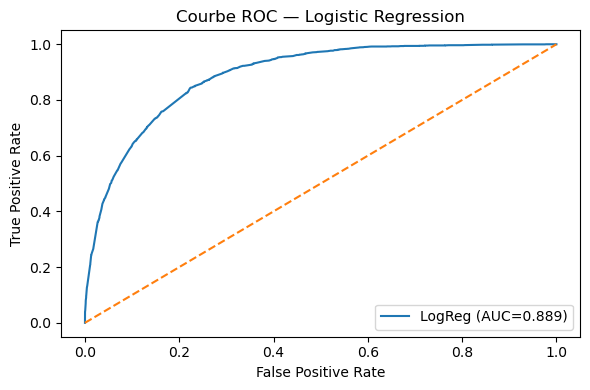

In [34]:

# ==========================
# Prédictions (LogReg)
# ==========================
y_pred_log = logreg.predict(X_test)

# proba de la classe ">50K" (si dispo)
y_proba_log = logreg.predict_proba(X_test)[:, 1]

print("✅ Évaluation — Logistic Regression")

# ==========================
# Métriques
# ==========================
acc = accuracy_score(y_test, y_pred_log)
prec = precision_score(y_test, y_pred_log, pos_label=">50K")
rec = recall_score(y_test, y_pred_log, pos_label=">50K")
f1 = f1_score(y_test, y_pred_log, pos_label=">50K")
auc = roc_auc_score(y_test_bin, y_proba_log)

print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1-score  : {f1:.3f}")
print(f"ROC-AUC   : {auc:.3f}")

# ==========================
# Rapport de classification
# ==========================
print("\nClassification report :")
print(classification_report(y_test, y_pred_log))

# ==========================
# Matrice de confusion
# ==========================
cm = confusion_matrix(y_test, y_pred_log, labels=["<=50K", ">50K"])
print("Matrice de confusion (lignes = vrai, colonnes = prédit) :\n", cm)

# ==========================
# Courbe ROC
# ==========================
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_log)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"LogReg (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC — Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()


Commentaire :

La régression logistique obtient une **accuracy de 84 %**, indiquant une bonne capacité globale de classification.  
Le **score ROC-AUC de 0,889** montre une excellente capacité du modèle à discriminer les individus ayant un revenu supérieur à 50K de ceux ayant un revenu inférieur ou égal à 50K, indépendamment du seuil de décision.

Concernant la classe minoritaire `>50K`, le modèle présente une **précision de 70,5 %**, ce qui signifie que la majorité des individus prédits comme ayant un revenu élevé le sont effectivement. Le **rappel de 57 %** indique toutefois que certains individus à revenu élevé ne sont pas détectés, ce qui traduit une tendance prudente du modèle.

La **matrice de confusion** met en évidence un nombre limité de faux positifs mais un volume plus important de faux négatifs pour la classe `>50K`, ce qui est cohérent avec le déséquilibre des classes observé dans le jeu de données.

Ce modèle constitue ainsi une **baseline robuste**, offrant un bon compromis entre interprétabilité et performance, et servira de point de comparaison pour des modèles plus complexes tels que la Random Forest.


##### Modèle 2 : Régression logistique avec réglages des paramètres

L’objectif de ce second modèle est d’améliorer les performances de la régression logistique initiale, en particulier sur la classe minoritaire correspondant aux individus ayant un revenu strictement supérieur à 50K.

Dans le modèle de référence, les résultats obtenus étaient globalement satisfaisants, notamment avec un score ROC-AUC élevé, traduisant une bonne capacité de discrimination. Toutefois, le rappel de la classe >50K restait limité (environ 57 %), ce qui signifie qu’une partie des individus à revenu élevé n’était pas correctement identifiée.

Afin de répondre à cette problématique, un ajustement des paramètres de la régression logistique a été envisagé. Les axes d’amélioration retenus sont les suivants : la prise en compte du déséquilibre des classes via la pondération (`class_weight`), ainsi que l’étude de l’effet de la régularisation à travers le paramètre C, qui contrôle la complexité du modèle.

Ces ajustements visent principalement à améliorer le rappel et le F1-score de la classe >50K, tout en conservant un modèle stable et interprétable.

  ###### Modèle 2.1 — Logistic Regression optimisée (class_weight="balanced")

In [35]:
logreg_balanced = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

logreg_balanced.fit(X_train, y_train)

print("✅ Logistic Regression (class_weight=balanced) entraînée")

✅ Logistic Regression (class_weight=balanced) entraînée


###### Evaluation

Évaluation — Logistic Regression (balanced)
Accuracy  : 0.788
Precision : 0.537
Recall    : 0.848
F1-score  : 0.657
ROC-AUC   : 0.889

Classification report :
              precision    recall  f1-score   support

       <=50K       0.94      0.77      0.85      7431
        >50K       0.54      0.85      0.66      2338

    accuracy                           0.79      9769
   macro avg       0.74      0.81      0.75      9769
weighted avg       0.84      0.79      0.80      9769



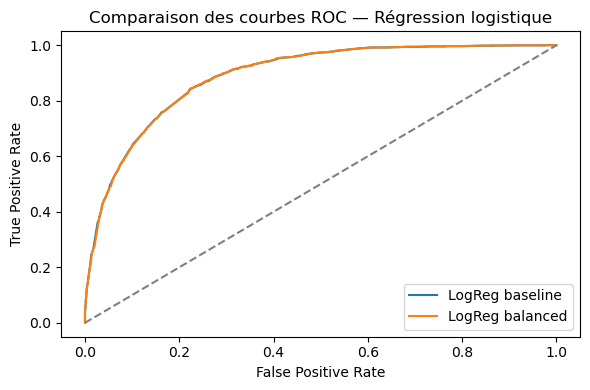

In [36]:
# Prédictions
y_pred_log_bal = logreg_balanced.predict(X_test)
y_proba_log_bal = logreg_balanced.predict_proba(X_test)[:, 1]

# Métriques
acc_bal = accuracy_score(y_test, y_pred_log_bal)
prec_bal = precision_score(y_test, y_pred_log_bal, pos_label=">50K")
rec_bal = recall_score(y_test, y_pred_log_bal, pos_label=">50K")
f1_bal = f1_score(y_test, y_pred_log_bal, pos_label=">50K")
auc_bal = roc_auc_score(y_test_bin, y_proba_log_bal)

print("Évaluation — Logistic Regression (balanced)")
print(f"Accuracy  : {acc_bal:.3f}")
print(f"Precision : {prec_bal:.3f}")
print(f"Recall    : {rec_bal:.3f}")
print(f"F1-score  : {f1_bal:.3f}")
print(f"ROC-AUC   : {auc_bal:.3f}")

print("\nClassification report :")
print(classification_report(y_test, y_pred_log_bal))

#courbe de ROC
fpr_bal, tpr_bal, _ = roc_curve(y_test_bin, y_proba_log_bal)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="LogReg baseline")
plt.plot(fpr_bal, tpr_bal, label="LogReg balanced")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparaison des courbes ROC — Régression logistique")
plt.legend()
plt.tight_layout()
plt.show()


Commentaire : L’utilisation d’une pondération des classes dans la régression logistique entraîne des changements significatifs dans les performances du modèle, en particulier pour la classe minoritaire correspondant aux individus dont le revenu est supérieur à 50K.

Le rappel de la classe >50K progresse fortement, passant de 57 % pour le modèle de référence à 85 % pour le modèle équilibré. Cette amélioration indique que le modèle équilibré identifie beaucoup mieux les individus à revenu élevé, réduisant ainsi le nombre de faux négatifs.

En contrepartie, la précision associée à cette classe diminue, passant de 70 % à 54 %. Cette baisse est attendue et s’explique par une augmentation du nombre de faux positifs, effet classique de l’utilisation du paramètre `class_weight="balanced"`.

L’accuracy globale du modèle diminue également, de 84 % à 79 %. Cette évolution est cohérente avec la correction du déséquilibre des classes, l’accuracy étant une métrique sensible à la classe majoritaire.

Enfin, le score ROC-AUC reste strictement identique (0,889) pour les deux modèles. Ce résultat est particulièrement important, car il montre que le pouvoir discriminant global du modèle ne change pas. Seul le seuil de décision effectif est modifié par la pondération des classes.

En conclusion, la régression logistique équilibrée apparaît plus adaptée lorsque l’objectif principal est d’identifier correctement les individus à revenu élevé (>50K), même si cela implique un léger compromis sur la précision et l’accuracy globale.


###### Modèle 2.2— Logistic Regression optimisée ( ajustement de c)

In [37]:
for C in [0.1, 1, 10]:
    logreg_tmp = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            C=C,
            solver="liblinear"
        ))
    ])
    logreg_tmp.fit(X_train, y_train)
    y_pred_tmp = logreg_tmp.predict(X_test)
    f1_tmp = f1_score(y_test, y_pred_tmp, pos_label=">50K")
    print(f"C={C} → F1-score (>50K) = {f1_tmp:.3f}")


C=0.1 → F1-score (>50K) = 0.657
C=1 → F1-score (>50K) = 0.657
C=10 → F1-score (>50K) = 0.657


Commentaire : Un ajustement du paramètre de régularisation C a été réalisé afin d’évaluer la sensibilité de la régression logistique équilibrée à la pénalisation des coefficients. Trois valeurs ont été testées (C = 0.1, 1 et 10), tout en conservant une pondération des classes (`class_weight="balanced"`).

Les résultats montrent que le F1-score de la classe >50K est strictement identique quelle que soit la valeur de C. Cette stabilité indique que la régularisation n’est pas un facteur limitant pour ce modèle et que les variables sélectionnées portent déjà l’essentiel de l’information nécessaire à la prédiction.

Ce comportement est un signal positif, suggérant l’absence de sur-apprentissage ainsi qu’une faible sensibilité du modèle aux hyperparamètres. En l’absence de gain de performance, la valeur par défaut C = 1 est conservée pour la suite de l’étude.

### Conclusion modèle régression logistique – Choix du modèle 

Afin de mieux prendre en compte le déséquilibre de la variable cible, une régression logistique avec pondération des classes (`class_weight="balanced"`) a été estimée. Ce choix permet d’accorder davantage d’importance à la classe minoritaire (>50K).

Le modèle équilibré améliore fortement le rappel de la classe >50K (0,85 contre 0,57 pour le modèle de référence), au prix d’une baisse de la précision et de l’accuracy globale. Le score ROC-AUC reste identique (0,889), indiquant que la capacité de discrimination du modèle est conservée.

Un ajustement du paramètre de régularisation `C` a été réalisé (C = 0.1, 1, 10). Les résultats montrent une stabilité parfaite du F1-score pour la classe >50K, suggérant que le modèle est peu sensible à ce paramètre et qu’il ne souffre ni de sur-apprentissage ni de sous-apprentissage.

Au regard de ces éléments, la régression logistique équilibrée (modele 2.1) est retenue comme modèle optimisé de référence pour la suite de l’étude.


### Random Forest

##### Modele 3.1 - Random forest (référence)

L’objectif du modèle Random Forest est d’explorer une approche plus flexible que la régression logistique, capable de capturer des relations non linéaires et des interactions complexes entre les variables explicatives. Contrairement aux modèles linéaires, le Random Forest repose sur un ensemble d’arbres de décision, ce qui lui permet de mieux s’adapter à des structures de données plus riches.

Ce modèle de référence est utilisé comme point de comparaison avec la régression logistique, notamment en termes de F1-score, de rappel sur la classe >50K et de ROC-AUC. L’objectif est d’évaluer si un modèle plus puissant permet d’améliorer la détection des individus à revenus élevés, tout en conservant une capacité de généralisation satisfaisante.

In [38]:
rf_baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])
rf_baseline.fit(X_train, y_train)

print("✅ Random Forest baseline entraînée")

✅ Random Forest baseline entraînée


##### Evaluation

✅ Évaluation — Random Forest (baseline)
Accuracy  : 0.833
Precision : 0.673
Recall    : 0.586
F1-score  : 0.627
ROC-AUC   : 0.884

Classification report :
              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      7431
        >50K       0.67      0.59      0.63      2338

    accuracy                           0.83      9769
   macro avg       0.77      0.75      0.76      9769
weighted avg       0.83      0.83      0.83      9769

Matrice de confusion (lignes = vrai, colonnes = prédit) :
 [[6764  667]
 [ 967 1371]]


<Figure size 600x400 with 0 Axes>

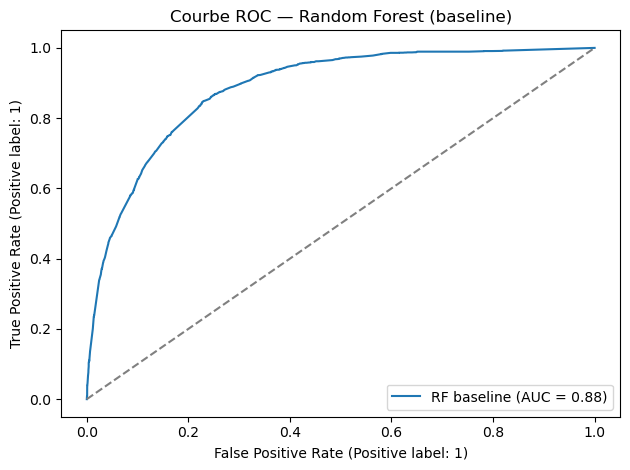

In [39]:
# ==========================
# Prédictions (RF baseline)
# ==========================
y_pred_rf = rf_baseline.predict(X_test)
y_proba_rf = rf_baseline.predict_proba(X_test)[:, 1]

print("✅ Évaluation — Random Forest (baseline)")

# ==========================
# Métriques
# ==========================
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, pos_label=">50K")
rec_rf = recall_score(y_test, y_pred_rf, pos_label=">50K")
f1_rf = f1_score(y_test, y_pred_rf, pos_label=">50K")
auc_rf = roc_auc_score(y_test_bin, y_proba_rf)

print(f"Accuracy  : {acc_rf:.3f}")
print(f"Precision : {prec_rf:.3f}")
print(f"Recall    : {rec_rf:.3f}")
print(f"F1-score  : {f1_rf:.3f}")
print(f"ROC-AUC   : {auc_rf:.3f}")

print("\nClassification report :")
print(classification_report(y_test, y_pred_rf))

# ==========================
# Matrice de confusion
# ==========================
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["<=50K", ">50K"])
print("Matrice de confusion (lignes = vrai, colonnes = prédit) :\n", cm_rf)

# ==========================
# Courbe ROC
# ==========================
plt.figure(figsize=(6,4))
RocCurveDisplay.from_predictions(y_test_bin, y_proba_rf, name="RF baseline")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("Courbe ROC — Random Forest (baseline)")
plt.tight_layout()
plt.show()


Commentaire : 
Le modèle Random Forest de référence présente des performances globales solides, avec une accuracy de 83,3 % et un score ROC-AUC de 0,884, indiquant une bonne capacité de discrimination entre les individus ayant un revenu supérieur à 50K et ceux dont le revenu est inférieur ou égal à ce seuil.

Concernant la classe minoritaire (>50K), le modèle obtient une précision de 67,3 % et un rappel de 58,6 %, conduisant à un F1-score de 0,627. Ces résultats traduisent une performance comparable à celle de la régression logistique de référence, avec une légère amélioration du rappel, mais sans gain significatif sur le F1-score.

La matrice de confusion met en évidence un nombre modéré de faux négatifs pour la classe >50K, indiquant que certains individus à revenu élevé ne sont pas détectés par le modèle. Ce comportement est cohérent avec l’absence de pondération des classes dans cette version de la Random Forest.

La courbe ROC confirme ces observations, avec une trajectoire nettement au-dessus de la diagonale aléatoire et un AUC proche de 0,88. Malgré la capacité du Random Forest à modéliser des relations non linéaires, ses performances restent proches de celles de la régression logistique, suggérant que des ajustements de paramètres pourraient être nécessaires pour exploiter pleinement son potentiel.

##### Modèle 3.2 - Random Forest optimisée (class_weight)

Les résultats du Random Forest de référence montrent des performances globales comparables à celles de la régression logistique, mais mettent également en évidence une sous-détection persistante de la classe >50K, qui reste minoritaire dans le jeu de données.

Afin d’améliorer la performance du modèle sur cette classe d’intérêt, une version optimisée du Random Forest est mise en place en appliquant les bonnes pratiques de gestion du déséquilibre des classes. Le paramètre class_weight="balanced" est introduit afin d’accorder davantage d’importance aux observations de la classe >50K lors de l’apprentissage.

Par ailleurs, plusieurs paramètres sont ajustés pour contrôler la complexité du modèle et limiter le risque de sur-apprentissage :

max_depth = 15 permet de restreindre la profondeur des arbres et d’éviter des règles trop spécifiques,

min_samples_leaf = 20 garantit des feuilles plus robustes et mieux généralisables,

n_estimators = 300 augmente la stabilité du modèle en s’appuyant sur un plus grand nombre d’arbres.

Ce choix de paramètres repose sur un tuning raisonné, visant à améliorer la capacité du modèle à identifier correctement les revenus élevés tout en maintenant un bon équilibre entre performance et robustesse.

In [40]:
rf_optimized = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=20,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])
rf_optimized.fit(X_train, y_train)

print("✅ Random Forest optimisée entraînée")


✅ Random Forest optimisée entraînée


##### Evaluation

✅ Évaluation — Random Forest optimisée
Accuracy  : 0.786
Precision : 0.533
Recall    : 0.856
F1-score  : 0.657
ROC-AUC   : 0.890

Classification report :
              precision    recall  f1-score   support

       <=50K       0.94      0.76      0.84      7431
        >50K       0.53      0.86      0.66      2338

    accuracy                           0.79      9769
   macro avg       0.74      0.81      0.75      9769
weighted avg       0.85      0.79      0.80      9769

Matrice de confusion (lignes = vrai, colonnes = prédit) :
 [[5676 1755]
 [ 337 2001]]


<Figure size 600x400 with 0 Axes>

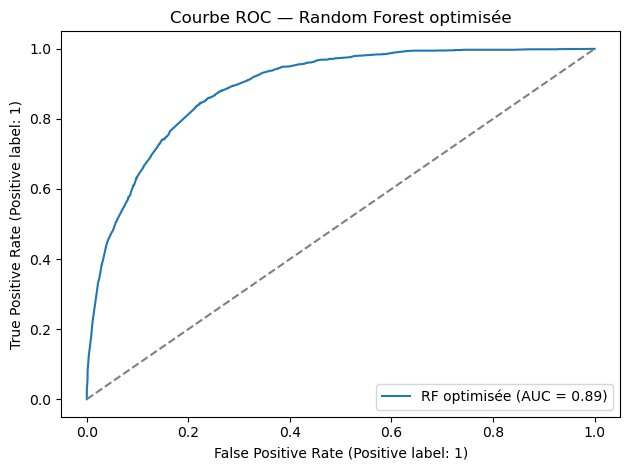

In [41]:
# ==========================
# Prédictions (RF optimisée)
# ==========================
y_pred_rf_opt = rf_optimized.predict(X_test)
y_proba_rf_opt = rf_optimized.predict_proba(X_test)[:, 1]

print("✅ Évaluation — Random Forest optimisée")

# ==========================
# Métriques
# ==========================
acc_rf_opt = accuracy_score(y_test, y_pred_rf_opt)
prec_rf_opt = precision_score(y_test, y_pred_rf_opt, pos_label=">50K")
rec_rf_opt = recall_score(y_test, y_pred_rf_opt, pos_label=">50K")
f1_rf_opt = f1_score(y_test, y_pred_rf_opt, pos_label=">50K")
auc_rf_opt = roc_auc_score(y_test_bin, y_proba_rf_opt)

print(f"Accuracy  : {acc_rf_opt:.3f}")
print(f"Precision : {prec_rf_opt:.3f}")
print(f"Recall    : {rec_rf_opt:.3f}")
print(f"F1-score  : {f1_rf_opt:.3f}")
print(f"ROC-AUC   : {auc_rf_opt:.3f}")

print("\nClassification report :")
print(classification_report(y_test, y_pred_rf_opt))

# ==========================
# Matrice de confusion
# ==========================
cm_rf_opt = confusion_matrix(y_test, y_pred_rf_opt, labels=["<=50K", ">50K"])
print("Matrice de confusion (lignes = vrai, colonnes = prédit) :\n", cm_rf_opt)

# ==========================
# Courbe ROC
# ==========================
plt.figure(figsize=(6,4))
RocCurveDisplay.from_predictions(
    y_test_bin, y_proba_rf_opt, name="RF optimisée"
)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("Courbe ROC — Random Forest optimisée")
plt.tight_layout()
plt.show()


Commentaire : Le modèle Random Forest optimisé présente des performances globalement comparables aux modèles précédemment testés, avec un ROC-AUC élevé (0,890), indiquant un excellent pouvoir discriminant entre les individus percevant un revenu inférieur ou supérieur à 50K.

L’optimisation a principalement permis d’améliorer significativement le rappel de la classe >50K, qui atteint 85,6 %, contre environ 58–59 % pour les modèles baseline. Cela signifie que le modèle identifie désormais correctement une très grande majorité des individus à revenus élevés, ce qui est particulièrement pertinent dans un contexte où l’objectif est de détecter au maximum les revenus >50K.

En contrepartie, la précision sur la classe >50K diminue (53,3 %). Cette baisse était attendue : le modèle génère davantage de faux positifs, conséquence directe d’un compromis en faveur du rappel. Cette logique est cohérente avec une stratégie orientée vers la détection plutôt que la certitude absolue.

L’accuracy globale diminue (≈ 79 %) par rapport au Random Forest baseline, ce qui est également un effet classique lorsque l’on corrige le déséquilibre des classes. Cependant, cette métrique est moins pertinente dans un contexte de classes déséquilibrées et ne remet pas en cause la qualité du modèle.

Le F1-score de la classe >50K atteint 0,657, soit un bon équilibre entre précision et rappel, très proche de celui obtenu avec la régression logistique équilibrée. Cela confirme que le modèle est robuste et stable après optimisation.

Enfin, la matrice de confusion montre une forte augmentation des vrais positifs (>50K correctement prédits), validant l’intérêt de l’optimisation lorsque l’objectif métier est d’identifier les individus à hauts revenus, même au prix de quelques erreurs supplémentaires.

### Conclusion modèle Random Forest – Choix du modèle 

Le Random Forest optimisé est un excellent modèle orienté détection, avec :

- un ROC-AUC élevé et stable,
- un rappel très élevé sur la classe >50K,
- un compromis assumé sur la précision.

Il constitue une alternative crédible à la régression logistique équilibrée, avec une capacité légèrement supérieure à capter des relations non linéaires, au prix d’une interprétabilité plus faible.

## Conclusion générale de la modélisation

| Modèle      | Accuracy | Precision (>50K) | Recall (>50K) | F1-score (>50K) | ROC-AUC | Objectif  |
| ----------- | -------- | ---------------- | ------------- | --------------- | ------- | --------- |
| Régression logistique (M1)       | 0.84     | 0.70               | 0.57        | 0.63            | 0.889   | référence |
| Régression logistique – optimisée (M2) | 0.79     | 0.54             | 0.85          | 0.66            | 0.889   | Maximiser la détection >50K |
| Random Forest (M3)         | 0.83     | 0.67             | 0.59          | 0.63            | 0.884   | Modèle non linéaire         |
| Random Forest – optimisée (M4)       | 0.79     | 0.53             | 0.86          | 0.66            | 0.890   | Détection optimale >50K     |


L’objectif principal de cette modélisation était de prédire le niveau de revenu (>50K ou ≤50K) dans un contexte de déséquilibre des classes, la classe >50K étant minoritaire.

Les modèles de référence (régression logistique et random forest baseline) présentent de bonnes performances globales, avec une accuracy élevée et un ROC-AUC proche de 0.89. Toutefois, ces modèles montrent une capacité limitée à détecter correctement les individus à revenus élevés, avec un rappel autour de 57–59 % pour la classe >50K.

Afin de corriger ce biais, des versions équilibrées et optimisées ont été testées. L’introduction du paramètre class_weight="balanced" a permis une amélioration très significative du rappel de la classe >50K, atteignant environ 85–86 %, aussi bien pour la régression logistique que pour le random forest. Cette amélioration s’accompagne logiquement d’une baisse de la précision et de l’accuracy globale, phénomène attendu dans un contexte de rééquilibrage des classes.

L’analyse comparative montre que :
- le ROC-AUC reste stable, indiquant que le pouvoir discriminant global du modèle ne change pas ;
- le F1-score de la classe >50K est maximisé (~0.66) pour les modèles équilibrés ;
- les modèles optimisés sont beaucoup plus adaptés à un objectif de détection des revenus élevés.

Choix final du modèle : Random Forest optimisée (M4) : 
Le modele est retenu car il présente le meilleur compromis recall / F1-score pour la classe >50K, il atteint le rappel le plus élevé (≈ 86 %), critère central de l’étude, il conserve un excellent ROC-AUC (0.890) et il est capable de capturer des relations non linéaires entre les variables explicatives et le revenu.
Ce modèle est donc le plus pertinent pour une utilisation opérationnelle, lorsque l’objectif est d’identifier un maximum d’individus à revenus élevés, même au prix de quelques faux positifs supplémentaires.

## Prédiction

L’objectif de cette dernière étape est d’utiliser le modèle final retenu (Random Forest optimisé) pour :
- produire des prédictions de revenus (>50K / ≤50K),
- estimer la probabilité associée à chaque prédiction,
- illustrer l’utilisation concrète du modèle dans un contexte opérationnel.

In [46]:
# chargement d'un jeux de données "nouvelle-data.csv"

df_new = pd.read_csv("../data/prediction/nouvelle_data.csv", sep=";")

print("df_new shape:", df_new.shape)
df_new.head()



df_new shape: (9681, 14)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,41,Never-worked,156105,Prof-school,5,Married-spouse-absent,Exec-managerial,Husband,Amer-Indian-Eskimo,Female,4397,0,54,Iran
1,67,Self-emp-not-inc,350376,Prof-school,7,Widowed,Transport-moving,Other-relative,Black,Male,0,0,38,Germany
2,54,Local-gov,274063,Prof-school,14,Never-married,Handlers-cleaners,Wife,Black,Male,0,0,50,Puerto-Rico
3,31,State-gov,78158,9th,9,Divorced,Exec-managerial,Husband,Black,Female,4378,0,23,Mexico
4,32,Self-emp-inc,286245,Some-college,6,Married-spouse-absent,Priv-house-serv,Wife,Black,Male,0,618,32,?


In [50]:
#nettoyage/recodage identique a l'entrainement
import numpy as np
import pandas as pd

def clean_data(df_input: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df_input.copy()

    # remplace les "-" par "_" (ex: capital-gain -> capital_gain)
    df_cleaned.columns = df_cleaned.columns.str.replace("-", "_", regex=False)

    # 2) remplacer "?" par "Non renseigné" (sur colonnes concernées)
    for c in ["occupation", "workclass", "native_country"]:
        if c in df_cleaned.columns:
            df_cleaned[c] = df_cleaned[c].astype(str).str.replace("?", "Non renseigné", regex=False)

    # 3) âge en classes
    if "age" in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned["age"]):
        bins = [0, 18, 30, 50, 65, float("inf")]
        labels = ["Moins de 18", "Entre 18 et 30 ans", "Entre 31 et 50 ans", "Entre 51 et 65 ans", "Plus de 65 ans"]
        df_cleaned["age"] = pd.cut(df_cleaned["age"], bins=bins, labels=labels, right=False)

    # 4) capital_gain / capital_loss (après renommage)
    if "capital_gain" in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned["capital_gain"]):
        df_cleaned["capital_gain"] = np.where(df_cleaned["capital_gain"] > 0, "Gain de capital", "Pas de gain de capital")

    if "capital_loss" in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned["capital_loss"]):
        df_cleaned["capital_loss"] = np.where(df_cleaned["capital_loss"] > 0, "Perte de capital", "Pas de perte de capital")

    # 5) hours_per_week
    if "hours_per_week" in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned["hours_per_week"]):
        df_cleaned["hours_per_week"] = pd.cut(
            df_cleaned["hours_per_week"],
            bins=[0, 40, 50, float("inf")],
            labels=["under_employed", "normally_employed", "over_employed"],
            right=False
        )

    # 6) native_country (USA / Not USA)
    if "native_country" in df_cleaned.columns:
        df_cleaned["native_country"] = np.where(
            df_cleaned["native_country"] == "United-States", "USA", "Not USA"
        )

    # 7) relationship – regroupement raisonné
    if "relationship" in df_cleaned.columns:
        df_cleaned["relationship"] = df_cleaned["relationship"].replace({
            "Husband": "Married",
            "Wife": "Married",
            "Own-child": "Own-child",
            "Not-in-family": "Others",
            "Other-relative": "Others",
            "Unmarried": "Unmarried"
        })

    # 8) race (White / Black / Other)
    if "race" in df_cleaned.columns:
        df_cleaned["race"] = np.where(
            df_cleaned["race"] == "White", "White",
            np.where(df_cleaned["race"] == "Black", "Black", "Other")
        )

    # 9) occupation mapping
    if "occupation" in df_cleaned.columns:
        occupation_mapping = {
            "Tech-support": "White Collar",
            "Craft-repair": "Blue Collar",
            "Other-service": "Other",
            "Sales": "Sales",
            "Exec-managerial": "White Collar",
            "Prof-specialty": "White Collar",
            "Handlers-cleaners": "Blue Collar",
            "Machine-op-inspct": "Blue Collar",
            "Adm-clerical": "White Collar",
            "Farming-fishing": "Agriculture",
            "Transport-moving": "Blue Collar",
            "Priv-house-serv": "Blue Collar",
            "Protective-serv": "Protective Services",
            "Armed-Forces": "Protective Services",
            "Non renseigné": "Other"
        }
        df_cleaned["occupation"] = df_cleaned["occupation"].replace(occupation_mapping)

    # 10) workclass regroupement
    if "workclass" in df_cleaned.columns:
        df_cleaned["workclass"] = df_cleaned["workclass"].replace({
            "Local-gov": "Gov",
            "State-gov": "Gov",
            "Federal-gov": "Gov",
            "Self-emp-not-inc": "Self_emp",
            "Self-emp-inc": "Self_emp",
            "Without-pay": "Other",
            "Never-worked": "Other",
            "Non renseigné": "Non renseigné"
        })

    # 11) education regroupement
    if "education" in df_cleaned.columns:
        df_cleaned["education"] = df_cleaned["education"].replace({
            "Preschool": "Primary", "1st-4th": "Primary", "5th-6th": "Primary",
            "7th-8th": "Middle_Low", "9th": "Middle_Low", "10th": "Middle_Low",
            "11th": "Middle_Low", "12th": "Middle_Low",
            "HS-grad": "HighSchool_SomeCollege", "Some-college": "HighSchool_SomeCollege",
            "Assoc-voc": "HighSchool_SomeCollege", "Assoc-acdm": "HighSchool_SomeCollege",
            "Bachelors": "Higher", "Masters": "Higher", "Prof-school": "Higher", "Doctorate": "Higher"
        })
    
    # Regroupement de marital_status (modalités courtes et en anglais)
    if "marital_status" in df_cleaned.columns:
        df_cleaned["marital_status"] = df_cleaned["marital_status"].replace({
        "Married-civ-spouse": "Married",
        "Married-AF-spouse": "Married",
        "Never-married": "Never_married",
        "Divorced": "Divorced",
        "Separated": "Separated",
        "Widowed": "Widowed",
        "Married-spouse-absent": "Separated"
        })

        
    #variable gender (2 modalités unique), educational_num (pas d'infos sur les modalités), pas regrouper

    return df_cleaned


# Application
df_new_clean = clean_data(df_new)

print("df_new_clean shape:", df_new_clean.shape)
df_new_clean.head()


df_new_clean shape: (9681, 14)


,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country
0,Entre 31 et 50 ans,Other,156105,Higher,5,Separated,White Collar,Married,Other,Female,Gain de capital,Pas de perte de capital,over_employed,Not USA
1,Plus de 65 ans,Self_emp,350376,Higher,7,Widowed,Blue Collar,Others,Black,Male,Pas de gain de capital,Pas de perte de capital,under_employed,Not USA
2,Entre 51 et 65 ans,Gov,274063,Higher,14,Never_married,Blue Collar,Married,Black,Male,Pas de gain de capital,Pas de perte de capital,over_employed,Not USA
3,Entre 31 et 50 ans,Gov,78158,Middle_Low,9,Divorced,White Collar,Married,Black,Female,Gain de capital,Pas de perte de capital,under_employed,Not USA
4,Entre 31 et 50 ans,Self_emp,286245,HighSchool_SomeCollege,6,Separated,Blue Collar,Married,Black,Male,Pas de gain de capital,Perte de capital,under_employed,Not USA


In [51]:
# selection des variables du modèle final dans ce jeu de données
features_model = ["education", "age", "hours_per_week", "occupation", "capital_gain", "marital_status"]

X_new = df_new_clean[features_model].copy()

print("X_new shape:", X_new.shape)
X_new.head()




X_new shape: (9681, 6)


,education,age,hours_per_week,occupation,capital_gain,marital_status
0,Higher,Entre 31 et 50 ans,over_employed,White Collar,Gain de capital,Separated
1,Higher,Plus de 65 ans,under_employed,Blue Collar,Pas de gain de capital,Widowed
2,Higher,Entre 51 et 65 ans,over_employed,Blue Collar,Pas de gain de capital,Never_married
3,Middle_Low,Entre 31 et 50 ans,under_employed,White Collar,Gain de capital,Divorced
4,HighSchool_SomeCollege,Entre 31 et 50 ans,under_employed,Blue Collar,Pas de gain de capital,Separated


In [56]:
#prédiction sur le nouveau jeu de données 

# Prédictions (classes + probabilités)
y_pred_new = rf_optimized.predict(X_new)
y_proba_new = rf_optimized.predict_proba(X_new)[:, 1]

# Tableau final
df_predictions_new = df_new.copy()
df_predictions_new["income_predicted"] = y_pred_new

df_predictions_new["proba_>50K"] = y_proba_new

df_predictions_new.head()


,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_predicted,proba_>50K
0,Entre 31 et 50 ans,Other,156105,Higher,5,Separated,White Collar,Married,Other,Female,Gain de capital,Pas de perte de capital,over_employed,Not USA,>50K,0.869370
1,Plus de 65 ans,Self_emp,350376,Higher,7,Widowed,Blue Collar,Others,Black,Male,Pas de gain de capital,Pas de perte de capital,under_employed,Not USA,<=50K,0.257304
2,Entre 51 et 65 ans,Gov,274063,Higher,14,Never_married,Blue Collar,Married,Black,Male,Pas de gain de capital,Pas de perte de capital,over_employed,Not USA,<=50K,0.479623
3,Entre 31 et 50 ans,Gov,78158,Middle_Low,9,Divorced,White Collar,Married,Black,Female,Gain de capital,Pas de perte de capital,under_employed,Not USA,<=50K,0.466755
4,Entre 31 et 50 ans,Self_emp,286245,HighSchool_SomeCollege,6,Separated,Blue Collar,Married,Black,Male,Pas de gain de capital,Perte de capital,under_employed,Not USA,<=50K,0.035149


In [60]:
df_predictions_new["income_predicted"].value_counts(normalize=True) * 100


income_predicted
<=50K    60.086768
>50K     39.913232
Name: proportion, dtype: float64

Commentaire : La répartition des classes prédites montre que le modèle identifie une proportion non négligeable d’individus à revenus supérieurs à 50K (environ 40 %), ce qui est cohérent avec l’objectif de correction du déséquilibre observé lors de l’apprentissage.

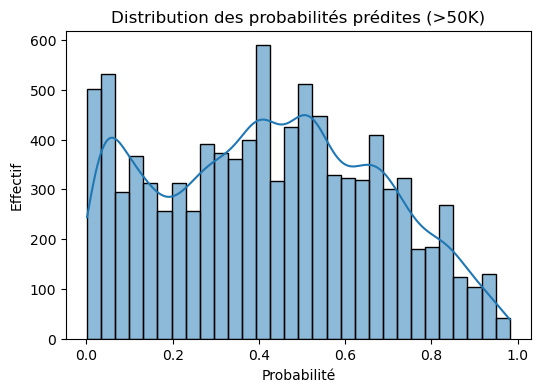

In [57]:
#distribution des probabilités (degré de confiance du modèle)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df_predictions_new["proba_>50K"], bins=30, kde=True)
plt.title("Distribution des probabilités prédites (>50K)")
plt.xlabel("Probabilité")
plt.ylabel("Effectif")
plt.show()


Commentaire : La distribution des probabilités prédites montre une dispersion relativement large, indiquant que le modèle distingue des profils très confiants (>0.8) et d’autres plus incertains. Cela permet d’adapter un seuil métier selon le niveau de risque acceptable.

In [53]:
#Seuil métier (0.7)
df_predictions_new["income_predicted_strict"] = np.where(
    df_predictions_new["proba_>50K"] >= 0.7,
    ">50K",
    "<=50K"
)

df_predictions_new[["income_predicted", "proba_>50K", "income_predicted_strict"]].head()


,income_predicted,proba_>50K,income_predicted_strict
0,>50K,0.869370,>50K
1,<=50K,0.257304,<=50K
2,<=50K,0.479623,<=50K
3,<=50K,0.466755,<=50K
4,<=50K,0.035149,<=50K


Commentaire : Un seuil de décision plus strict (0.7) peut être appliqué afin de ne retenir que les prédictions les plus fiables pour la classe >50K, selon les contraintes métier (réduction des faux positifs).

In [59]:
# Top individus les plus probables (>50K)
df_predictions_new.sort_values("proba_>50K", ascending=False).head(5)


,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_predicted,proba_>50K
3526,Entre 51 et 65 ans,Private,155586,Higher,12,Married,White Collar,Others,White,Female,Gain de capital,Perte de capital,over_employed,Not USA,>50K,0.981461
3559,Entre 51 et 65 ans,Self_emp,205350,Higher,9,Married,White Collar,Married,Other,Female,Gain de capital,Pas de perte de capital,over_employed,Not USA,>50K,0.981461
1613,Entre 51 et 65 ans,Self_emp,189787,Higher,11,Married,White Collar,Own-child,Other,Female,Gain de capital,Perte de capital,over_employed,Not USA,>50K,0.981461
7121,Entre 51 et 65 ans,Other,111124,Higher,10,Married,White Collar,Own-child,Other,Male,Gain de capital,Pas de perte de capital,over_employed,Not USA,>50K,0.981461
7095,Entre 51 et 65 ans,Non renseigné,210299,Higher,10,Married,White Collar,Own-child,Other,Female,Gain de capital,Perte de capital,over_employed,Not USA,>50K,0.981461


Commentaire : Les individus présentant les probabilités les plus élevées de revenus supérieurs à 50K combinent généralement des caractéristiques associées à des profils favorables : 50-65 ans, travail dans le secteur privé/employé/autres, niveau d'éducation élevé, marié, de sexe féminin, gain de capital, temps de travail élevé et non américain.

## Exportation des données et sauvegarde du modele final


In [61]:
# ===============================
# Export des résultats de prédiction
# ===============================

output_path = "../data/prediction/prediction_random_forest.csv"

df_predictions_new.to_csv(
    output_path,
    sep=";",
    index=False
)

print(f"✅ Fichier de prédiction exporté : {output_path}")

✅ Fichier de prédiction exporté : ../data/prediction/prediction_random_forest.csv


In [63]:

# ===============================
# Sauvegarde modele final
# ===============================
rf_optimized.fit(X_train, y_train)

MODEL_PATH = Path("../outputs/jobs/rf_optimized.joblib")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(rf_optimized, MODEL_PATH)

print("✅ Modèle Random Forest optimisé sauvegardé :", MODEL_PATH)

✅ Modèle Random Forest optimisé sauvegardé : ..\outputs\rf_optimized.joblib
